In [19]:
import gym
import random
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras.backend as K
import tensorflow as tf
from collections      import deque
from keras.models     import Sequential, Model
from keras.layers     import Dense, Input, Add
from keras.optimizers import Adam


from tqdm import tqdm

# Agent

In [20]:
class Agent():
    
    def __init__(self, sess, state_size, action_size, weights=None):
        
        self.sess = sess
        
        self.state_size = state_size
        self.action_size = action_size

        self.gamma = 0.99
        self.learning_rate = 0.001
        self.memory = deque(maxlen=2000)
        self.exploration_rate = 1.0
        self.exploration_min = 0.01
        self.exploration_decay = 0.995

        self.actor = self.build_actor()
        self.actor_input = self.actor.input
        self.target_actor = self.build_actor()
        self.critic, self.critic_state_input, self.critic_action_input = self.build_critic()
        self.target_critic, _, _ = self.build_critic()

        if weights != None:
            self.actor.load_weights(weights[0])
            self.critic.load_weights(weights[1])
            self.update_target_models()

        self.actor_critic_grad = tf.placeholder(tf.float32, [None, action_size]) # where we will feed de/dC (from critic)

        actor_weights = self.actor.trainable_weights
        self.actor_grads = tf.gradients(self.actor.output, 
                                        actor_weights, 
                                        -self.actor_critic_grad) # dC/dA (from actor)

        grads = zip(self.actor_grads, actor_weights)
        #
        #optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        #capped_gvs = [(tf.clip_by_value(grad, -0.1, 0.1), var) for grad, var in grads]
        #self.optimize = optimizer.apply_gradients(capped_gvs)
        
        self.optimize = tf.train.AdamOptimizer(learning_rate=self.learning_rate).apply_gradients(grads)

        self.critic_grads = tf.gradients(self.critic.output, self.critic_action_input) # where we calcaulte de/dC for feeding above

            # Initialize for later gradient calculations
        self.sess.run(tf.initialize_all_variables())
    
    

    def build_actor(self, layer_size=128):
        model = Sequential()
        model.add(Dense(layer_size, input_dim=self.state_size, 
                        activation='relu', kernel_initializer='glorot_uniform'))
        model.add(Dense(layer_size, activation='relu', kernel_initializer='glorot_uniform'))
        model.add(Dense(self.action_size, activation='softmax', kernel_initializer='glorot_uniform'))
        
        model.compile(loss='mse', optimizer=('rmsprop'))
        return model
    
    def build_critic(self):
        state_input = Input(shape=(self.state_size,), name='state_input')
        state_h1 = Dense(128, activation='relu')(state_input)
        state_h2 = Dense(128)(state_h1)

        action_input = Input(shape=(self.action_size,), name='action_input')
        action_h1    = Dense(128)(action_input)

        merged    = Add()([state_h2, action_h1])
        merged_h1 = Dense(128, activation='relu')(merged)
        output = Dense(1, activation='relu')(merged_h1)
        model  = Model(input=[state_input,action_input], output=output)

        #adam  = Adam(lr=0.001)
        model.compile(loss="mse", optimizer='rmsprop')
        return model, state_input, action_input

        
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append([state, action, reward, next_state, done])
        
    def act(self, state, exploration=False):
        
        if (exploration == True and np.random.rand() <= self.exploration_rate):
            return random.randrange(self.action_size)
        
        else:
            policy = self.actor.predict(state, batch_size=1).flatten()
            return np.random.choice(self.action_size, 1, p=policy)[0]
   
   
        
    def replay(self, batch_size=32):
        sample_size = min(len(self.memory), batch_size)
        sample_batch = random.sample(self.memory, sample_size)
        
        #Train critic
        for state, action, reward, next_state, done in sample_batch:
            next_action = self.target_actor.predict(next_state)
            if not done:
                reward = reward + self.gamma * self.target_critic.predict([next_state, next_action])[0][0]
            self.critic.fit([state, action], [reward], verbose=0)
            
        #Train actor
            predicted_action = self.actor.predict(state)
            grads = self.sess.run(self.critic_grads, feed_dict={
                    self.critic_state_input:  state,
                    self.critic_action_input: predicted_action
            })[0]

            self.sess.run(self.optimize, feed_dict={
                self.actor_input: state,
                self.actor_critic_grad: grads
            })
        
        
        self.update_target_models()
        
    def next_action(self, state):
        return self.act(state, True)
        
        
        
    def update_target_models(self):
        for model, target_model in zip([self.actor, self.critic], [self.target_actor, self.target_critic]):
            weights = model.get_weights()
            target_weights = target_model.get_weights()
            for i in range(len(target_weights)):
                target_weights[i] =  weights[i]
            target_model.set_weights(target_weights) 
            
    def one_hot_encoding(self, x):
        vect = np.zeros(self.action_size)
        vect[x] = 1
        vect = np.reshape(vect, [1, self.action_size])
        return vect
        
    def train(self, env, nb_episodes=1000):
        pbar = tqdm(range(nb_episodes))
        all_rewards = []
        for i in pbar:
            state = np.reshape(env.reset(), [1, self.state_size])
            done = False
            total_reward = 0
            while not done:
                action = self.act(state, exploration=True)
                next_state, reward, done, _ = env.step(action)
                total_reward += reward
                next_state = np.reshape(next_state, [1, self.state_size])
                action = self.one_hot_encoding(action)
                self.remember(state, action, reward, next_state, done)
                #self.replay()
                if done:
                    self.replay()
                    self.exploration_rate = max(self.exploration_min, self.exploration_rate * self.exploration_decay)
                    break
                state = next_state            
            pbar.set_description("episode: %s, score: %s, exploration_rate: %s " % (i, total_reward, self.exploration_rate))
            all_rewards.append(total_reward)
    
        return all_rewards
    

# Environement

In [21]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
sess = tf.Session()
K.set_session(sess)
agent = Agent(sess, state_size, action_size)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/david.bertoin/anaconda3/envs/IRT_RL2/lib/python3.5/site-packages/ipykernel_launcher.py:71: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`


# Training

episode: 999, score: 9.0, exploration_rate: 0.01 : 100%|██████████| 1000/1000 [05:41<00:00,  2.93it/s]


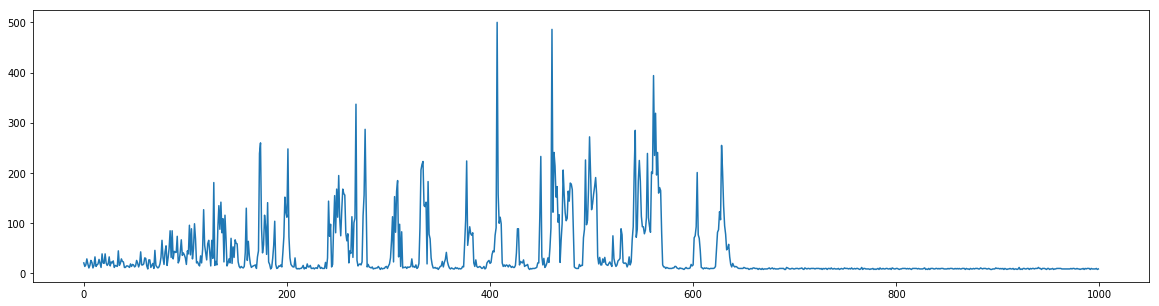

In [22]:
scores = agent.train(env, 1000)
plt.figure(figsize=(20,5))
plt.plot(scores)

# Playing

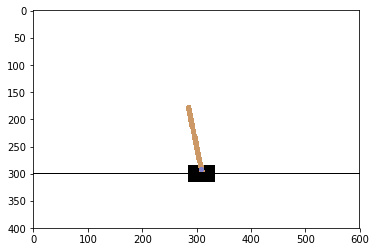

In [17]:
from distant_gym_render import distant_render
distant_render(env, agent, state_size)

# Save weights

In [9]:
agent.critic.save_weights("./weights/AC_critic_model.h5")
agent.actor.save_weights("./weights/AC_actor_model.h5")

In [10]:
agent = Agent(sess, state_size, action_size, weights=["./weights/AC_actor_model.h5", "./weights/AC_critic_model.h5"])

/home/david.bertoin/anaconda3/envs/IRT_RL2/lib/python3.5/site-packages/ipykernel_launcher.py:71: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`
